Epoch 01/10 | Train Loss: 0.3846 | Val Loss: 0.3319 | Train Acc: 83.47% | Val Acc: 84.45%
Epoch 02/10 | Train Loss: 0.3141 | Val Loss: 0.3225 | Train Acc: 85.24% | Val Acc: 84.90%
Epoch 03/10 | Train Loss: 0.3074 | Val Loss: 0.3197 | Train Acc: 85.36% | Val Acc: 85.07%
Epoch 04/10 | Train Loss: 0.3039 | Val Loss: 0.3177 | Train Acc: 85.45% | Val Acc: 85.12%
Epoch 05/10 | Train Loss: 0.3010 | Val Loss: 0.3173 | Train Acc: 85.68% | Val Acc: 85.13%
Epoch 06/10 | Train Loss: 0.2986 | Val Loss: 0.3163 | Train Acc: 85.72% | Val Acc: 85.38%
Epoch 07/10 | Train Loss: 0.2966 | Val Loss: 0.3155 | Train Acc: 85.90% | Val Acc: 85.35%
Epoch 08/10 | Train Loss: 0.2943 | Val Loss: 0.3150 | Train Acc: 86.05% | Val Acc: 85.30%
Epoch 09/10 | Train Loss: 0.2926 | Val Loss: 0.3147 | Train Acc: 86.22% | Val Acc: 85.29%
Epoch 10/10 | Train Loss: 0.2909 | Val Loss: 0.3153 | Train Acc: 86.17% | Val Acc: 85.32%

=== Final Evaluation ===
Accuracy  : 85.32%
Precision : 61.17%
Recall    : 31.60%
F1 Score  : 41.68

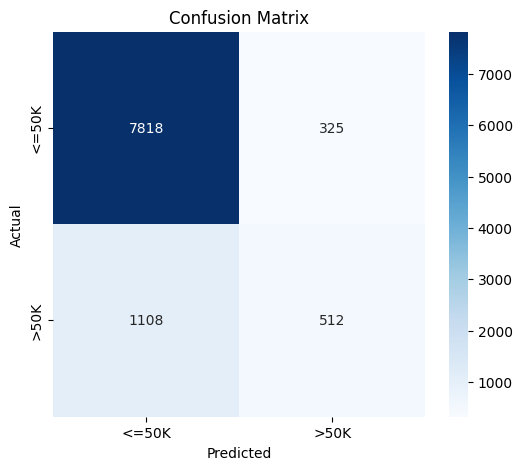

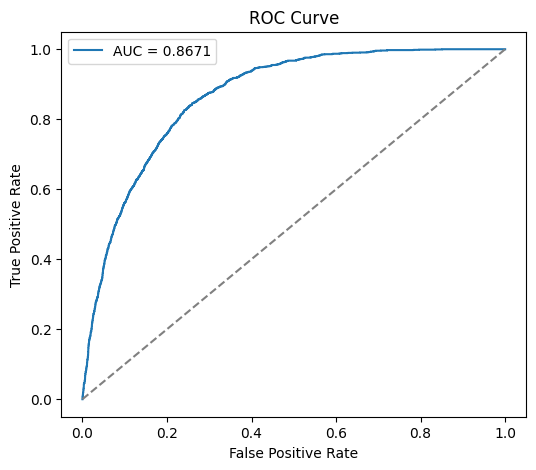

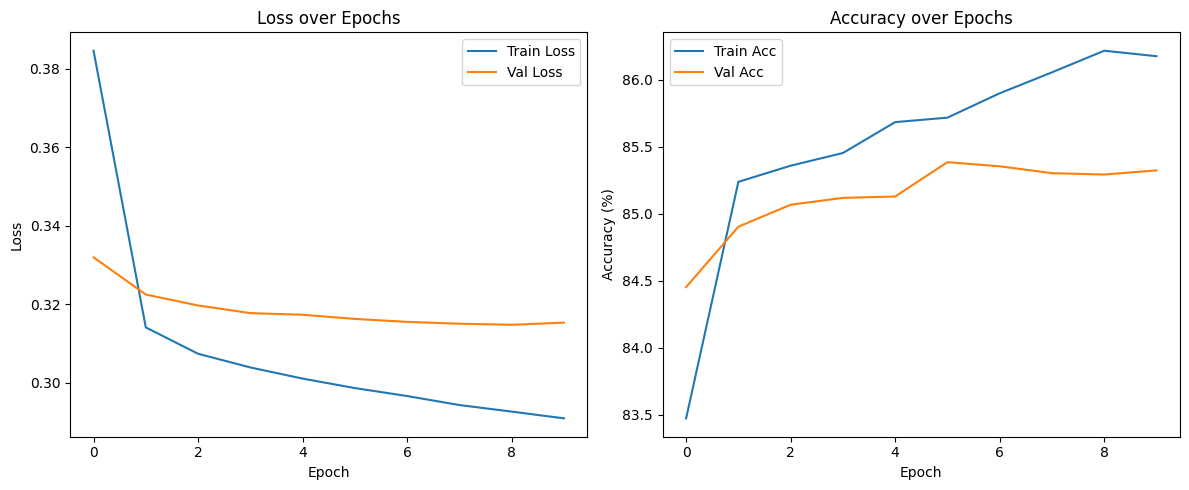

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv(r'income.csv')

# Data cleaning
data.drop_duplicates(inplace=True)

# Separate features and target
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# One-hot encoding
X = pd.get_dummies(X)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Dataset & Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define classifier model
class IncomeClassifier(nn.Module):
    def __init__(self, input_dim):
        super(IncomeClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.classifier(x)

model_pt = IncomeClassifier(X_train_tensor.shape[1])

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.0001)

# Training loop
epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model_pt.train()
    running_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels.unsqueeze(1)).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model_pt.eval()
    val_loss, correct_val = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model_pt(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels.unsqueeze(1)).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(correct_val / len(test_dataset) * 100)

    print(f"Epoch {epoch+1:02d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_accuracies[-1]:.2f}%")

# Evaluation
model_pt.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_pt(inputs)
        preds = (outputs > 0.5).float()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.squeeze().numpy())
        y_prob.extend(outputs.squeeze().numpy())

# Metrics
print("\n=== Final Evaluation ===")
print(f"Accuracy  : {accuracy_score(y_true, y_pred) * 100:.2f}%")
print(f"Precision : {precision_score(y_true, y_pred) * 100:.2f}%")
print(f"Recall    : {recall_score(y_true, y_pred) * 100:.2f}%")
print(f"F1 Score  : {f1_score(y_true, y_pred) * 100:.2f}%")
print(f"AUC Score : {roc_auc_score(y_true, y_prob) * 100:.2f}%")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_prob):.4f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/10


C:\Users\muham\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7835 - loss: 0.4625 - val_accuracy: 0.8450 - val_loss: 0.3292
Epoch 2/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8534 - loss: 0.3213 - val_accuracy: 0.8508 - val_loss: 0.3214
Epoch 3/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8537 - loss: 0.3135 - val_accuracy: 0.8507 - val_loss: 0.3182
Epoch 4/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8576 - loss: 0.3055 - val_accuracy: 0.8493 - val_loss: 0.3161
Epoch 5/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8588 - loss: 0.3036 - val_accuracy: 0.8504 - val_loss: 0.3152
Epoch 6/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8597 - loss: 0.2994 - val_accuracy: 0.8515 - val_loss: 0.3131
Epoch 7/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8606 - loss: 0.2934 - val_accuracy: 0.8518 - val_loss: 0.3131
Epoch 8/10
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8598 - loss: 0.2968 - val_accurac

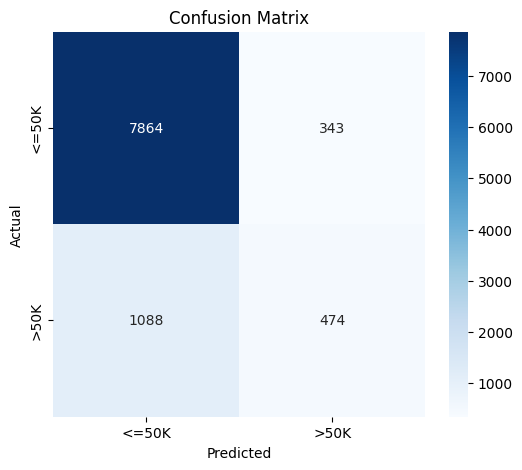

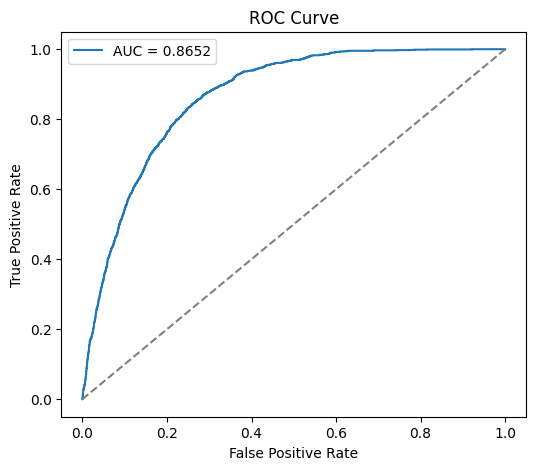

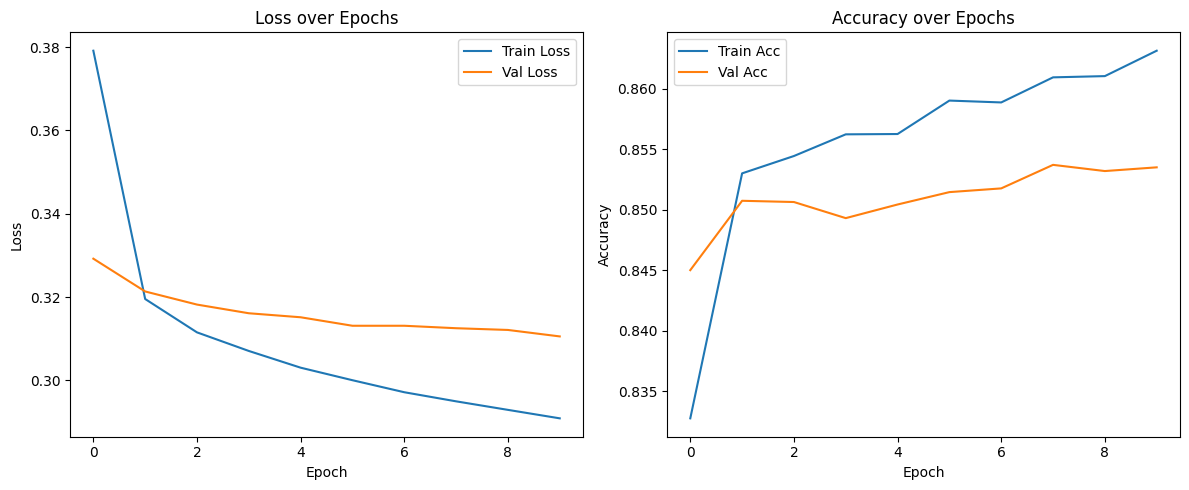

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load data
data = pd.read_csv(r'income.csv')
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# One-hot encoding
X = pd.get_dummies(X)

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

# Evaluation
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n=== Final Evaluation ===")
print(f"Accuracy  : {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision : {precision_score(y_test, y_pred) * 100:.2f}%")
print(f"Recall    : {recall_score(y_test, y_pred) * 100:.2f}%")
print(f"F1 Score  : {f1_score(y_test, y_pred) * 100:.2f}%")
print(f"AUC Score : {roc_auc_score(y_test, y_pred_prob) * 100:.2f}%")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.4f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import random
# Sample Test Prediction
idx = random.randint(0, len(X_test)-1)
sample_input = X_test[idx].reshape(1, -1)
sample_output = model.predict(sample_input).item()
sample_class1 = '>50K' if sample_output > 0.5 else '<=50K'

# 🧪 Sample Test Prediction
idx = random.randint(0, len(X_test_tensor)-1)
sample_input = X_test_tensor[idx].unsqueeze(0)
with torch.no_grad():
    sample_output = model_pt(sample_input).item()
    sample_class2 = '>50K' if sample_output > 0.5 else '<=50K'

print(f"\nSample Test Prediction (index {idx})")
print(f"Actual Class                : {'>50K' if y_test_tensor[idx].item() == 1 else '<=50K'}\n")
print(f"Predicted Prob              : {sample_output:.4f}\n")
print(f"Predicted Class PyTorch     : {sample_class1}")
print(f"Predicted Class Tensorflow  : {sample_class2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Sample Test Prediction (index 7096)
Actual Class                : <=50K

Predicted Prob              : 0.0048

Predicted Class PyTorch     : <=50K
Predicted Class Tensorflow  : <=50K


# ANALISIS HASIL DARI CLASSIFICATION

**Hasil dari PyTorch:**

- **Accuracy**: 85.32%
- **Precision**: 61.17%
- **Recall**: 31.60%
- **F1 Score**: 41.68%
- **AUC Score**: 86.71%

**Hasil dari Tensorflow:**

- **Accuracy**: 85.35%
- **Precision**: 58.02%
- **Recall**: 30.35%
- **F1 Score**: 39.85%
- **AUC Score**: 86.52%

**Hasil Prediction dari Sample:**

- **Actual Class**: <=50K
- **Predicted Prob**: 0.0048
- **Predicted Class PyTorch**: <=50K
- **Predicted Class Tensorflow**: <=50K

Untuk keseluruhan, keduanya sudah sangat bagus di skor AUC, yaitu skor yang menguji kinerja untuk klasifikasi. Pada pengetesan dengan sample, kedua jenis menghasilkan nilai yang sama dengan actual.

# ACCURACY, PRECISION, RECALL, F1 SCORE, DAN AUC SCORE

## Accuracy
Accuracy mengukur proporsi dari prediksi yang benar dari keseluruhan prediksi.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Keterangan:**
- \($ TP $\): True Positive (Benar Positif)
- \($ TN $\): True Negative (Benar Negatif)
- \($ FP $\): False Positive (Salah Positif)
- \($ FN $\): False Negative (Salah Negatif)



## Precision
Precision mengukur proporsi dari prediksi positif yang benar dari keseluruhan prediksi positif.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Keterangan:**
- \($ TP $\): True Positive (Benar Positif)
- \($ FP $\): False Positive (Salah Positif)



## Recall
Recall mengukur proporsi dari prediksi positif yang benar dari keseluruhan kasus positif sebenarnya.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**Keterangan:**
- \($ TP $\): True Positive (Benar Positif)
- \($ FN $\): False Negative (Salah Negatif)



## F1 Score
F1 Score adalah rata-rata harmonis dari Precision dan Recall. F1 Score memberikan keseimbangan antara Precision dan Recall.

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$



## AUC Score
AUC (Area Under the Curve) Score adalah ukuran kinerja model klasifikasi. AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). AUC berkisar antara 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan kinerja model yang lebih baik.

$$
\text{AUC} = \int_{0}^{1} TPR(dFPR)
$$

**Keterangan:**
- \($ TPR $\): True Positive Rate (Tingkat Benar Positif)
- \($ FPR $\): False Positive Rate (Tingkat Salah Positif)


